In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from functools import reduce
import joblib


%matplotlib inline
pd.set_option("display.max_columns", None)
%config IPCompleter.greedy = True

In [3]:
route = pd.read_pickle("./route_14__.pkl")
bank_holidays = pd.read_pickle("./bank_holidays__.pkl")
weather = pd.read_pickle("./weather__.pkl")

In [4]:
route

,DayOfService,TripID,LineID,RouteID,ProgrNumber,StopPointID,Direction,PlannedTime_Dep,PlannedTime_Arr,ActualTime_Dep,ActualTime_Arr,LastUpdate
0,01-JAN-18 00:00:00,5957977,14,14_16,42,1353,2,37129,33600,35105,35105,08-JAN-18 17:21:10
1,01-JAN-18 00:00:00,5970398,14,14_16,42,1353,2,60472,55800,57731,57720,08-JAN-18 17:21:10
2,01-JAN-18 00:00:00,5965245,14,14_16,42,1353,2,62272,57600,59787,59787,08-JAN-18 17:21:10
3,01-JAN-18 00:00:00,5965247,14,14_16,42,1353,2,72577,68400,70337,70322,08-JAN-18 17:21:10
4,01-JAN-18 00:00:00,5959637,14,14_16,42,1353,2,74377,70200,72113,72104,08-JAN-18 17:21:10
...,...,...,...,...,...,...,...,...,...,...,...,...
2678405,31-DEC-18 00:00:00,8581163,14,14_16,72,244,2,39871,36000,39746,39746,16-JAN-19 18:27:21
2678406,31-DEC-18 00:00:00,8589342,14,14_16,72,244,2,27017,24300,27035,27035,16-JAN-19 18:27:21
2678407,31-DEC-18 00:00:00,8584102,14,14_16,72,244,2,27917,25200,28301,28301,16-JAN-19 18:27:21
2678408,31-DEC-18 00:00:00,8581161,14,14_16,72,244,2,28817,26100,29251,29251,16-JAN-19 18:27:21


In [5]:
weather.head()

,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,date,hour
0,Dublin,53.349805,-6.26031,4.15,-6.49,3.84,5.79,990,,,87,12.86,240,40,520,Rain,light intensity shower rain,09n,2018-01-01,0
1,Dublin,53.349805,-6.26031,3.71,-2.28,3.00,5.80,1008,,,75,5.66,240,40,802,Clouds,scattered clouds,03n,2018-01-02,0
2,Dublin,53.349805,-6.26031,5.18,-3.85,5.00,6.66,985,,,87,10.80,260,75,520,Rain,light intensity shower rain,09n,2018-01-03,0
3,Dublin,53.349805,-6.26031,6.06,0.07,5.31,7.29,996,,,87,6.69,230,75,803,Clouds,broken clouds,04n,2018-01-04,0
4,Dublin,53.349805,-6.26031,4.09,-0.08,3.24,5.68,990,,,87,3.60,220,75,803,Clouds,broken clouds,04n,2018-01-05,0


In [6]:
def route_time_process(df):
    df['hour'] = (df['ActualTime_Arr']//3600) % 24
    return df
route =route_time_process(route)

In [7]:
def convert_2_datetime(df, col):
    df[col] = pd.to_datetime(df[col]) 
    return df
route = convert_2_datetime(route, 'DayOfService')
bank_holidays = convert_2_datetime(bank_holidays, 'date')
weather = convert_2_datetime(weather, 'date')

In [8]:
def add_bank_holiday(df, col, bank_holidays, date_col):
    df['bank_holiday'] = np.where(df[col].astype(str).isin(set(list(bank_holidays[date_col].astype(str)))),1,0)
    return df
route = add_bank_holiday(route, 'DayOfService', bank_holidays, 'date')

In [9]:
len(route[route['bank_holiday'] == 1])

38462

In [91]:
col = ['hour', 'StopPointID', 'ProgrNumber','temp', 'pressure', 'humidity', 'clouds_all', 'wind_speed',
       'weather_main','bank_holiday','day_of_week','day_of_year', 'journey_time']

def merge_and_clean(df1, df2, col):
    combined_df = pd.merge(df1, df2,  how='inner', left_on=['DayOfService', 'hour'], 
                           right_on = ['date', 'hour'],
                           suffixes=('_route','_weather'))
#     combined_df['Direction'] = combined_df['Direction'].astype('int')
    combined_df['day_of_week'] = combined_df['DayOfService'].dt.dayofweek
    combined_df['day_of_year'] = combined_df['DayOfService'].dt.dayofyear
    combined_df['journey_time'] = combined_df['ActualTime_Dep'] - combined_df['PlannedTime_Arr']
    combined_df['journey_time'] = combined_df['journey_time'].apply(lambda x: x if x > 0 else 0)
    combined_df['StopPointID'] = combined_df['StopPointID'].astype('category')
    combined_df['weather_main'] = combined_df['weather_main'].astype('category')
    combined_df = combined_df[col]
    return combined_df
df = merge_and_clean(route, weather, col)

In [92]:
df.shape

(2678410, 13)

In [93]:
# fig, ax = plt.subplots(figsize=(24,6))
# ax = sns.countplot(x="weather_main", data=df)
# plt.xticks(rotation=45)

In [94]:
def one_hot_encoding(df, col_list):
    df = pd.get_dummies(df, prefix = col_list, columns = col_list)
    return df

In [95]:
def remove_outlier(df):    
    df = df[np.abs(df["journey_time"]-df["journey_time"].mean())<=(1.5*df["journey_time"].std())]
    return df

In [96]:
# df = one_hot_encoding(df, ['StopPointID'])
print ("Shape Of The Before Ouliers: ",df.shape)
df = remove_outlier(df)
print ("Shape Of The After Ouliers: ",df.shape)

Shape Of The Before Ouliers:  (2678410, 13)
Shape Of The After Ouliers:  (2461614, 13)


[Text(0, 0.5, 'journey_time'), Text(0.5, 0, 'hour')]

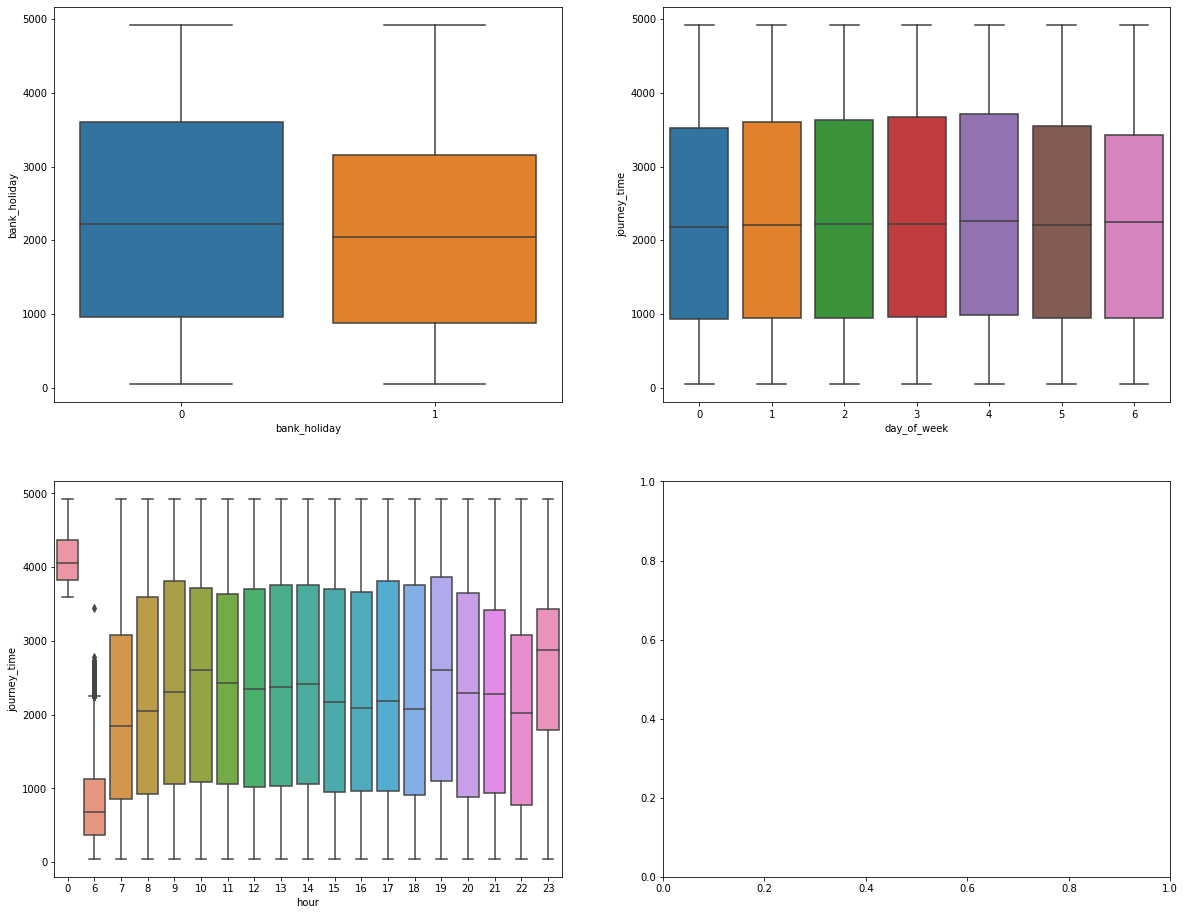

In [97]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,16))
sns.boxplot(data=df,y="journey_time",x="bank_holiday",orient="v",ax=axes[0][0])
sns.boxplot(data=df,y="journey_time",x="day_of_week",orient="v",ax=axes[0][1])
sns.boxplot(data=df,y="journey_time",x="hour",orient="v",ax=axes[1][0])
axes[0][0].set(ylabel='bank_holiday')
axes[0][1].set(xlabel='day_of_week', ylabel='journey_time')
axes[1][0].set(xlabel='hour', ylabel='journey_time')

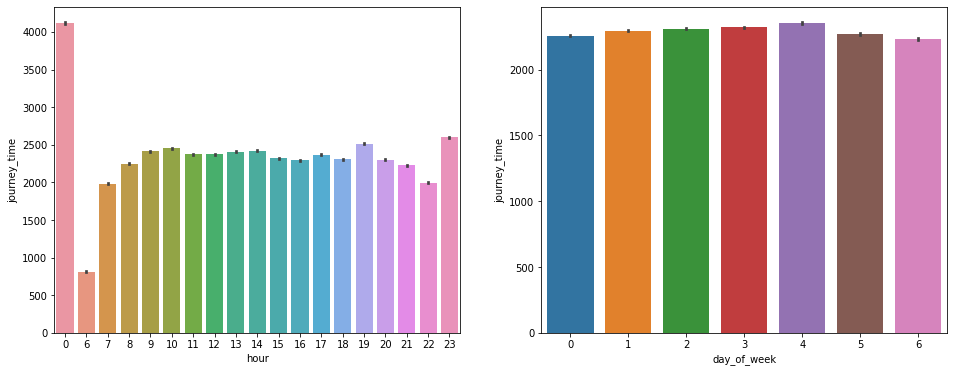

In [98]:
# # Slow runnimg

# Finding distribution between different time
fig, axes = plt.subplots(ncols=2, figsize=(16,6))
sns.barplot(data=df, y = 'journey_time', x = 'hour', ax=axes[0])
sns.barplot(data=df, y = 'journey_time', x = 'day_of_week', ax=axes[1])

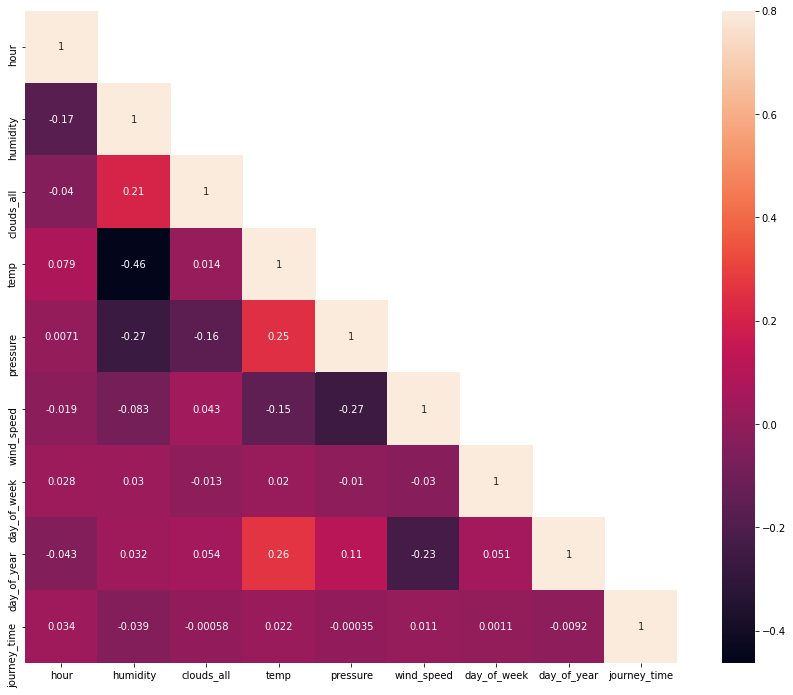

In [99]:
#Finding correlation of continuous features
col = ['hour', 'humidity', 'clouds_all',
       'temp', 'pressure', 'wind_speed',
       'day_of_week', 'day_of_year', 'journey_time']
corrMatt = df[col].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots(figsize=(16,12))
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

[Text(0, 0.5, 'd'), Text(0.5, 0, 'journey_time')]

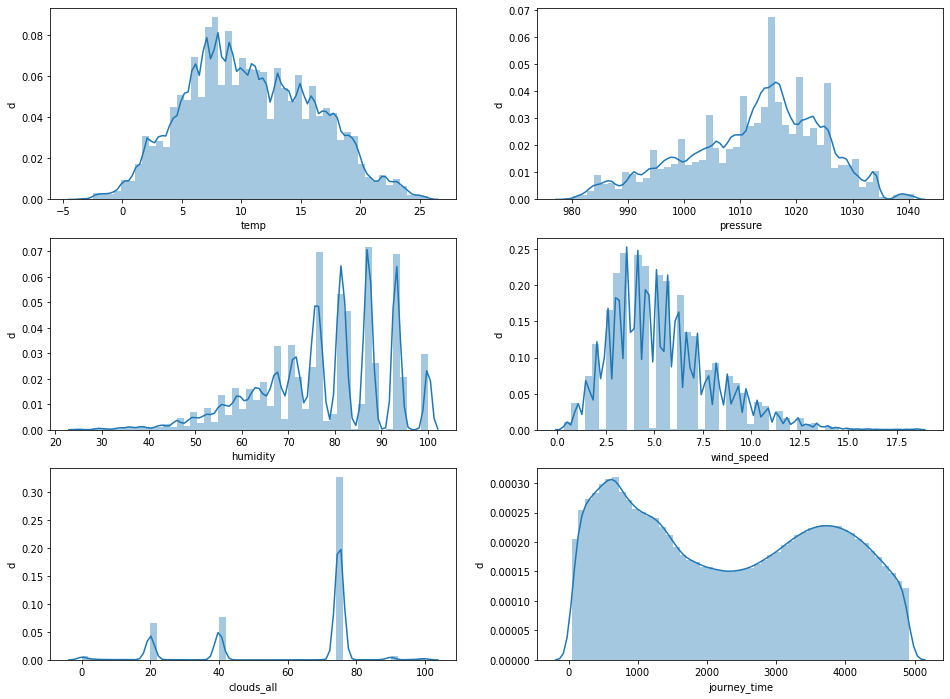

In [100]:
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(16,12))
sns.distplot(df["temp"],ax=axes[0][0])
sns.distplot(df["pressure"],ax=axes[0][1])
sns.distplot(df["humidity"],ax=axes[1][0])
sns.distplot(df["wind_speed"],ax=axes[1][1])
sns.distplot(df["clouds_all"],ax=axes[2][0])
sns.distplot(df["journey_time"],ax=axes[2][1])

axes[0][0].set(xlabel='temp', ylabel='d')
axes[0][1].set(xlabel='pressure', ylabel='d')
axes[1][0].set(xlabel='humidity', ylabel='d')
axes[1][1].set(xlabel='wind_speed', ylabel='d')
axes[2][0].set(xlabel='clouds_all', ylabel='d')
axes[2][1].set(xlabel='journey_time', ylabel='d')

In [101]:
def time_transform(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df = df.drop([col], axis = 1)
    return df

In [102]:
df = time_transform(df, 'day_of_week', 7)
df = time_transform(df, 'hour', 24)

In [103]:
y = df['journey_time']
x = df.loc[:, df.columns != 'journey_time']

In [104]:
y_avg = y.mean()
y_avg

2296.646866243042

In [105]:
size = len(x) * 9 //10 
x_train, x_test = x[:size], x[size:]
y_train, y_test = y[:size], y[size:]
print(size)

2215452


In [106]:
x_train.dtypes

StopPointID        category
ProgrNumber           int64
temp                float64
pressure              int64
humidity              int64
clouds_all            int64
wind_speed          float64
weather_main       category
bank_holiday          int64
day_of_year           int64
day_of_week_sin     float64
day_of_week_cos     float64
hour_sin            float64
hour_cos            float64
dtype: object

In [117]:
%%time
#Model validation
lgb_turned = lgb.LGBMRegressor()
lgb_turned.fit(x_train, y_train, categorical_feature=['StopPointID', 'weather_main'])
scores_rmse=cross_val_score(lgb_turned, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
scores_mae=cross_val_score(lgb_turned, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("- RMSE: {:.5f}".format(np.mean(scores_rmse)))
print("- MAE: {:.5f}".format(np.mean(scores_mae)))

/Users/pie_trick/Desktop/Semester3/venv/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['StopPointID', 'weather_main']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


- RMSE: -301.92316
- MAE: -217.36709
CPU times: user 7min 19s, sys: 6.98 s, total: 7min 26s
Wall time: 1min 5s


In [118]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor()
dummy.fit(x_train, y_train)
scores_rmse=cross_val_score(dummy, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
scores_mae=cross_val_score(dummy, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("- RMSE: {:.5f}".format(np.mean(scores_rmse)))
print("- MAE: {:.5f}".format(np.mean(scores_mae)))

- RMSE: -1440.02975
- MAE: -1281.51948


In [119]:
model_name = 'route_14__lgbm_model.pkl'
joblib.dump(lgb_turned, model_name)

['route_14__lgbm_model.pkl']

In [120]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 2.94 s, sys: 88.5 ms, total: 3.03 s
Wall time: 413 ms


In [121]:
y_test = y_test.reset_index()["journey_time"]
metrics.mean_absolute_error(y_test, y_prediction)

259.72377176185944

In [122]:
_prediction = pd.Series(y_prediction)

In [123]:
x_test

,StopPointID,ProgrNumber,temp,pressure,humidity,clouds_all,wind_speed,weather_main,bank_holiday,day_of_year,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2407146,1054,21,12.99,982,81,75,11.3,Rain,0,332,0.974928,-0.222521,-0.5,-0.866025
2407147,4709,23,12.99,982,81,75,11.3,Rain,0,332,0.974928,-0.222521,-0.5,-0.866025
2407148,1037,24,12.99,982,81,75,11.3,Rain,0,332,0.974928,-0.222521,-0.5,-0.866025
2407149,1038,25,12.99,982,81,75,11.3,Rain,0,332,0.974928,-0.222521,-0.5,-0.866025
2407150,2998,26,12.99,982,81,75,11.3,Rain,0,332,0.974928,-0.222521,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678404,2856,64,9.19,1035,81,75,5.7,Clouds,0,365,0.000000,1.000000,-0.5,0.866025
2678405,2856,64,9.19,1035,81,75,5.7,Clouds,0,365,0.000000,1.000000,-0.5,0.866025
2678406,496,48,9.19,1035,81,75,5.7,Clouds,0,365,0.000000,1.000000,-0.5,0.866025
2678407,242,70,9.19,1035,81,75,5.7,Clouds,0,365,0.000000,1.000000,-0.5,0.866025


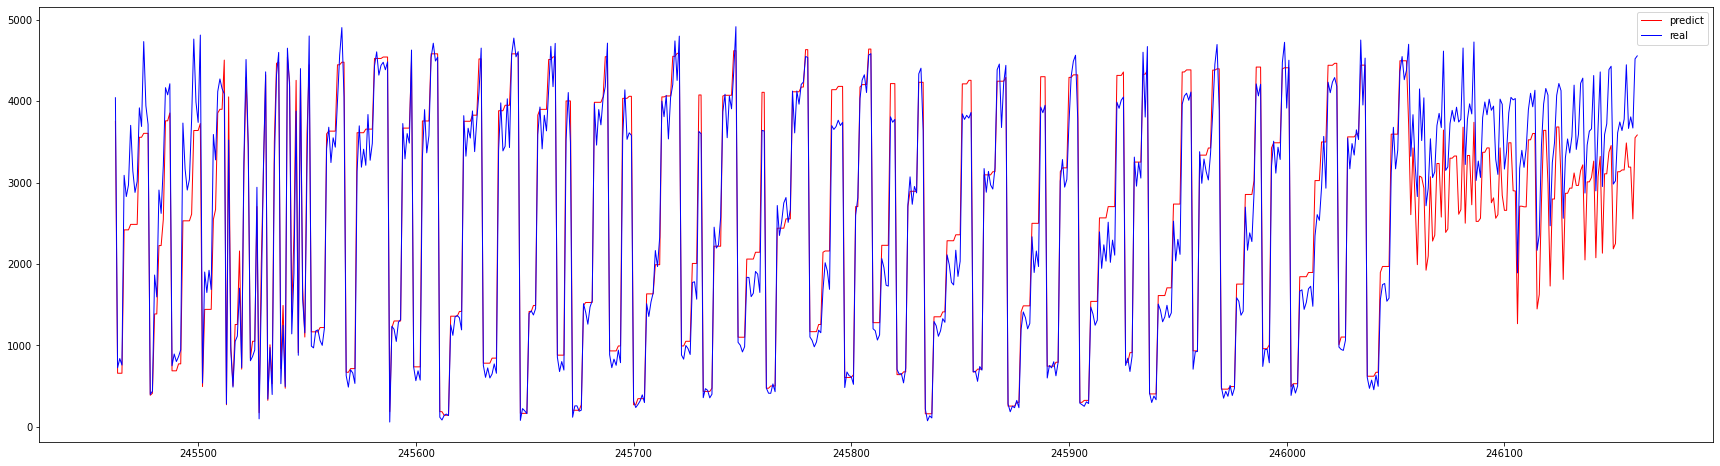

In [124]:
fig, ax = plt.subplots(figsize=(30,8))
plt.plot(_prediction[-700:], linewidth=1, color = 'red', label = 'predict')
plt.plot(y_test[-700:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()

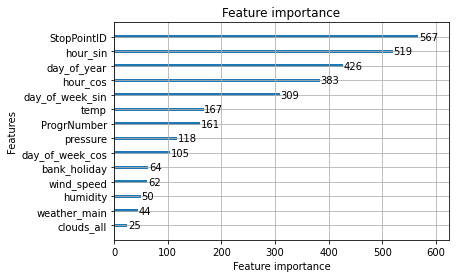

In [125]:
lgb.plot_importance(model)